# Introduction to Agent-Based Modeling (Python-based)
## Paul Macklin, Indiana University (macklinp@iu.edu) 
## Version 2: February 2, 2022

This Jupyter notebook accompanies a two-lecture series that introduces agent-based modeling (in biology) by building a basic agent-based model in Python, and then explores more developed cloud-hosted agent-based models created with [PhysiCell](http://PhysiCell.org). 

This notebook and the accompanying lectures are available as open education resources under the [CC-BY 4.0 license](https://creativecommons.org/licenses/by/4.0/). Please visit the following GitHub repository for the latest version: 

https://github.com/physicell-training/Python_ABM_crashcourse

### Version History
#### Version 1. February 16, 2021
Initial version. 

#### Version 2. February 2, 2022
Fixed typographical errors, added improved plotting, and fixed nuisance np.int vs int warnings.  

### Section 1. Declaring a class in Python 
Let's start by declaring a class. 

The name of this class is `Agent`. It is a template for a software object. Any specific software object created from this template is an *instance* of the class. 

Its default constructor is `__init__`. Its single input variable (argument) is **self**: the software object (instance) created by the class. Inside of `__init__`, we define the member data, which are attached to `self`. 

Every Python class must have a default constructor with syntax `__init__(self)`. 

This particular class has a member function (`move_me`), with arguments `self` (always required!), `dx`, and `dy`. It also has a method `display` to show its current state. 

In [1]:
class Agent:
    def __init__( self ): # default constructor
        self.hidden_variable = False; # no such thing as private in Python
        self.position = [0,0]; 
        self.hunger = 0.0;
        self.ID = 0; 
        return; 

    def move_me( self , dx, dy ): # member function 
        self.position[0] += dx ; 
        self.position[1] += dy; 
        return; 
        
    def display( self ):
        print( str(self.ID) + ' at ' + str(self.position) + ' has hunger level ' 
              + str(self.hunger) )

Now, let's create an instance of this class named Bob.

In [2]:
Bob = Agent(); 
Bob.display() 

0 at [0, 0] has hunger level 0.0


Now, let's set Bob's ID to 1. 

In [3]:
Bob.ID = 1 
Bob.display()

1 at [0, 0] has hunger level 0.0


Now, let's use the member function to move Bob one right, one down: 

In [5]:
Bob.move_me( 1 , -1 )
Bob.display()

Alice = Agent()
Alice.ID = 2
Alice.hunger = 0.5 

Bob.display()
Alice.display()



1 at [2, -2] has hunger level 0.0
1 at [2, -2] has hunger level 0.0
2 at [0, 0] has hunger level 0.5


### Section 2. Loading key libraries. 
Let's load the "standard" Python libraries we'll need, and set matplotlib to plot inline (for now). 

In [6]:
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline

### Section 3. Creating a basic microenvironment 

Let's now write a basic `Environment` class.

We'll introduce a basic chemical factor (a growth substrate) $c$ that obeys diffusion and decay: 

$$ \frac{ \partial c}{\partial t} = D \nabla^2 c - \lambda c $$ 

First, we're going to add a basic Cartesian mesh: $X$ will hold regularly-spaced x-coordinates $a \le x \le b$, and $Y$ will hold y-coordinates with $c \le y \le d$. We'll have $m \times n$ lattice points, with 

$$ \Delta x = \frac{b-a}{m-1} , \textrm{ and } \Delta y = \frac{d-c}{n-1}.$$

And then $x_i = a + i\Delta x$ and $y_j = c+j \Delta y$. 

We'll use numpy linspaces for X and Y, and a numpy matrix (initially zeros) to store the substrates. 

To make this easy, we'll put most of the initial sizing into the default constructor (`__init__`), and we'll use the `setup` function to set the physical parameters and apply the initial condition. 

In [7]:
# Declare environment class
class Environment:
    def __init__( self , shape=[-100,-100,100,100],  m=2 , n=2 ):
        self.a = shape[0]
        self.b = shape[2]
        self.c = shape[1]
        self.d = shape[3]
        self.m = m; 
        self.n = n; 
        self.dx = (self.b-self.a)/(m-1); 
        self.dy = (self.d-self.c)/(n-1);
        self.X = np.linspace( self.a, self.b , m )
        self.Y = np.linspace( self.c, self.d, n )
        self.C = np.zeros((m,n)); 
        return; 
    def setup( self , D=1000, decay=0.1 , initial=1.0, boundary=1.0 ):
        self.D = D; 
        self.decay = decay; # In Python you can evidently declare more class elements in methods
        # set boundary values 
        self.C = boundary * np.ones((self.m,self.n))
        # set interior values to initial value 
        for j in range(1,self.n-1):
            for i in range(1,self.m-1):
                self.C[i,j] = initial ; 
        print( 'Length scale: ' + str( np.sqrt(self.D/self.decay) ) )
        return; 

Now, let's test it on a $[-100,200] \times [0,400]$ domain with $31\times 41$ lattice points. Diffusion coefficient 1000, decay rate 0.1, initial value of 0.5, and boundary value 1.     

We'll do a contour plot to make sure it's good. 

Length scale: 100.0


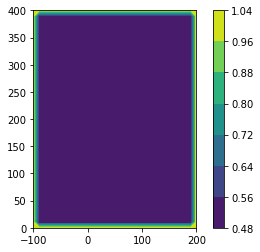

In [8]:
E = Environment( [-100,0,200,400] , 31,41 ) 

E.setup( 1000, 0.1 , 0.5 , 1 )

plt.contourf( E.X, E.Y, np.transpose( E.C ) )
plt.axis('image')
plt.colorbar()

### Section 4. Adding diffusion and built-in plotting 
We'll solve the diffusion-decay PDE with an explicit finite difference method. If $(x_i,y_j)$ 
is some lattice site and $t_n = n \Delta t$ is a time, then let's write: 
$$
c^n_{i,j} = c( x_i, y_j , t_n )
$$

Using this notation and standard finite differenes, we have: 
$$
\frac{ c^{n+1}_{i,j} - c^{n}_{i,j} }{\Delta t} = 
D \left( \frac{ c^n_{i+1,j}-2 c^n_{i,j} - c^n_{i-1,j}  }{\Delta x^2 }   + 
\frac{ c^n_{i,j+1}-2 c^n_{i,j} - c^n_{i,j-1}  }{\Delta y^2 }     
\right) - \lambda c^n_{i,j}
$$

Then, we can algebraically solve for $c^{n+1}_{i,j}$: 
$$
c^{n+1}{i,j} = 
c^{n}{i,j} 
+ 
\frac{D \Delta t}{\Delta x^2} 
\left( c^n_{i+1,j}-2 c^n_{i,j} - c^n_{i-1,j} \right)
+ 
\frac{D \Delta t}{\Delta y^2} 
\left( c^n_{i,j+1}-2 c^n_{i,j} - c^n_{i,j-1}  \right) 
- \lambda \Delta t c^{n}_{i,j}
$$
We can clean this up to: 
$$
A = \frac{D\Delta t}{\Delta x^2} , \hspace{0.25in} 
B = \frac{D \Delta t}{\Delta y^2} , \hspace{0.25in}
C = \Delta t \lambda 
$$
and then 
$$
c^{n+1}_{i,j} = \left( 1 - (2A+2B) - C \right)c^n_{i,j} 
+ A c^n_{i-1,j} + A c^n_{i+1,j} +  B c^n_{i,j-1} + B c^n_{i,j+1} 
$$
We'll iterate through our interior (non-boundary) points using this computational stencil. 

One more thing: when you do `b = a` in Python, it doesn't actually copy `a` to create a new `b`. It instead makes a pointer to `a` and stores it at `b`. This makes it efficient to pass objects to functions, but it has a serious downside: operating on your "copy" `b` changes the original `a`. You have to use `copy` (or sometimes `deepcopy`) to get around this Python design choice. 

Let's re-define the `Environment` class with this algorithm. 

In [9]:
import copy 

# Declare environment class
class Environment:
    def __init__( self , shape=[-100,-100,100,100],  m=3 , n=3 ):
        self.a = shape[0]
        self.b = shape[2]
        self.c = shape[1]
        self.d = shape[3]
        self.m = m; 
        self.n = n; 
        self.dx = (self.b-self.a)/(m-1); 
        self.dy = (self.d-self.c)/(n-1);
        self.X = np.linspace( self.a, self.b , m )
        self.Y = np.linspace( self.c, self.d, n )
        self.C = np.zeros((m,n)); 
        return; 
    def setup( self , D=1000, decay=0.1 , initial=1.0, boundary=1.0 ):
        self.D = D; 
        self.decay = decay;  
        # set all to the boundary values
        self.C = boundary*np.ones((self.m,self.n))
        # now set interior values to the initial value 
        for j in range(1,self.n-1):
            for i in range(1,self.m-1):
                self.C[i,j] = initial ; 
        print( 'Length scale: ' + str( np.sqrt(self.D/self.decay) ) )
        return; 
    def update( self , dt=0.001 ):
        # define constants for simplicity 
        A = self.D * dt / ( self.dx**2 )
        B = self.D * dt / ( self.dy**2 )
        C = self.decay * dt 
        # copy the prior solution. 
        old = self.C.copy(); # make sure this is a real copy and not a reference.         
        # finite differences for decay-diffusion 
        for i in range(1,self.m-1):
            for j in range(1,self.n-1):
                self.C[i,j] = (1-2*A-2*B-C)*old[i,j] + A*(old[i-1,j]+old[i+1,j]) + B*( old[i,j-1]+old[i,j+1] );     
        return; 
    def plot( self ):
        plt.clf()
        plt.contourf( self.X, self.Y, np.transpose( self.C ) )
        plt.axis('image')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
        plt.pause(0.0001) # helps with animation
        
# a startup function for full-screen plots 
def fullscreen_setup( fignum=1 , pause_time=2):
    %matplotlib qt 
    plt.figure(fignum)
    plt.clf()
    figManager = plt.get_current_fig_manager()
    figManager.full_screen_toggle() 
    plt.pause(pause_time); # some time to switch windows if needed 

Now, let's try it out. We'll define a domain, with initial condition 0.5 and boundary value 1. 

Let's use a mesh size of $\Delta x = \Delta y = 20.$ For a finite difference scheme like this, there are restrictions on how big of a time step size we can use without losing accuracy and numerical stability: 

$$\Delta t \le \frac{ \Delta x^2}{2n D},$$

where $n$ is the number of spatial dimensions (here, $n = 2$). 

If $\Delta x = 20$ and $D = 10000$, then we need: 
$$\Delta t \le \frac{400}{4\cdot 10000} = 0.01$$

Let's run update every 0.01 minutes and plot every 200 time steps. 

In [15]:
# declare an environment 
E = Environment( [-250,-250,250,250] , 26,26 ) 
# set up
E.setup( 10000, 1 , 0.5 , 1 )

dt = E.dx**2 / (2 * 2 * E.D )

print(dt)

# prepare for full-screen plots
fullscreen_setup()

# main test loop
for n in range(100):
    if( n % 10  == 0 ):
        E.plot()
        # plt.show() 
        # plt.pause(0.001)
    E.update( dt )
    
E.plot() 

Length scale: 1000.0
0.01


### Section 5. A cell class (version 1)
Let's write a cell class that does the following: 
* updates cell velocity by exchanging spring-like forces with other cells. 
* there is a random component to velocity (due to random actin dynamics etc)
* updates cell position based on the velocity. 
We'll also make a list of cells to keep track of them all. 

In [16]:
all_cells = list(); 

class Cell:
    def __init__( self ):
        self.position = np.array( [0.0,0.0] ); 
        self.velocity = np.array( [0.0,0.0] );
        self.mechanics_distance = 30.0; 
        self.equilibrium_spacing = 20.0;
        self.mechanics_contant = 1.0; 
    def update_velocity( self, dt , env , all_cells ):
        self.velocity = np.array([0.0,0.0])
        # spring-like interactions with cells 
        for c in all_cells: 
            displacement = c.position - self.position 
            dist = np.linalg.norm( displacement )
            if( dist < self.mechanics_distance and dist > 1e-16 ):
                dv = dist - self.equilibrium_spacing 
                displacement = displacement / dist; 
                displacement = displacement * dv; 
                displacement = displacement * self.mechanics_contant; 
                self.velocity = self.velocity + displacement 
        angle = 6.28318530718 * np.random.uniform(); 
        perturbation_size = 0.1 * self.mechanics_contant; 
        self.velocity[0] += perturbation_size * np.cos(angle)
        self.velocity[1] += perturbation_size * np.sin(angle)
        return
    def update_position( self, dt , env, all_cells ):
        self.position = self.position + dt*self.velocity; 
        return; 

Now, let's make a few cells with random positions contained in the environment and plot. 

In [19]:
all_cells = list()

# make a plotting function 
def plot_cells( env, all_cells ):
    env.plot()
    num_cells = len( all_cells )
    positions = np.zeros( (num_cells,2) ); 
    for n in range(num_cells):
        positions[n,:] = all_cells[n].position 
    plt.plot( positions[:,0] , positions[:,1] , 'wo' )
    plt.axis('image')
    plt.show();
    plt.pause(0.0001)
    return; 

fullscreen_setup(1,0.01)

# now make 10 cells with random positions 
number_of_cells = 10;
center = [ 0.5*(E.a+E.b) , 0.5*(E.c+E.d)]
for n in range(number_of_cells):
    c = Cell(); # create cell. 
    r = 5 * np.random.normal();
    angle = 6.28318530718 * np.random.uniform(); 
    c.position[0] = center[0] + r * np.cos(angle)
    c.position[1] = center[1] + r * np.sin(angle)
    
    c.equilibrium_spacing = 15 + 10*np.random.uniform(); 
    all_cells.append(c)
  
plot_cells( E, all_cells )

Now, let's run the mechanics steps a few times and plot.

In [20]:
dt = 0.1 

fullscreen_setup(1,0.001)

for n in range( 250 ):
    for c in all_cells:
        c.update_velocity( dt , E, all_cells )
    for c in all_cells:
        c.update_position( dt , E, all_cells )
    if( n % 25 == 0 ):
        plot_cells( E, all_cells ) 

### Section 6. Adding cell division and death. (Cell v2) 
Let's add division and death to the `Cell` class. 

When a cell `c` divides, we want to make a fully copy of it and place it at the end of the `all_cells` data structure. 

Recall that in Python, the operation `b = a` doesn't actually make a new object `b` that is a copy of `a`. Instead, it makes a pointer, and changing `b` turns out to change `a`. This is stupid and deeply frustrating, but Python had good reasons to do it. We can solve it by using the `deepcopy` function in the `copy` package. 

When a cell `c` dies, we want to remove it from the `all_cells` data structure. 

Let's build these basic methods into the an upgraded `Cell` class. 

In [21]:
import copy

all_cells = list(); 

class Cell:
    def __init__( self ):
        self.position = np.array( [0.0,0.0] ); 
        self.velocity = np.array( [0.0,0.0] );
        self.mechanics_distance = 30.0; 
        self.equilibrium_spacing = 20.0;
        self.mechanics_contant = 1.0;  
    def update_velocity( self, dt , env , all_cells ):
        self.velocity = np.array([0.0,0.0])
        # spring-like interactions with cells 
        for c in all_cells: 
            displacement = c.position - self.position 
            dist = np.linalg.norm( displacement )
            if( dist < self.mechanics_distance and dist > 1e-16 ):
                dv = dist - self.equilibrium_spacing 
                displacement = displacement / dist; 
                displacement = displacement * dv; 
                displacement = displacement * self.mechanics_contant; 
                self.velocity = self.velocity + displacement 
        angle = 6.28318530718 * np.random.uniform(); 
        perturbation_size = 0.1 * self.mechanics_contant; 
        self.velocity[0] += perturbation_size * np.cos(angle)
        self.velocity[1] += perturbation_size * np.sin(angle)
        return
    def division( self, all_cells ):
        # make a brand new cell
        c = copy.deepcopy( self ); 
        # append it to the data structure 
        all_cells.append( c ); 
        # set its position to be near its parent cell
        r = self.equilibrium_spacing; 
        angle = np.random.uniform()
        c.position[0] = r*np.cos(angle)
        c.position[1] = r*np.sin(angle)
        return; 
    def death( self, all_cells ):
        all_cells.remove( self )
        del self; 
    def update_position( self, dt , env, all_cells ):
        self.position = self.position + dt*self.velocity; 
        return; 

Now, let's test it! 

we'll create 10 cells. Every 50 time steps, we'll divide a random cell. Every 200 steps, we'll kill a random cell 

In [22]:
all_cells.clear() 

# now make 10 cells with random positions 
number_of_cells = 10;
center = [ 0.5*(E.a+E.b) , 0.5*(E.c+E.d)]
for n in range(number_of_cells):
    c = Cell(); # create cell. 
    r = 5 * np.random.normal();
    angle = 6.28318530718 * np.random.uniform(); 
    c.position[0] = center[0] + r * np.cos(angle)
    c.position[1] = center[1] + r * np.sin(angle)
    all_cells.append(c)

fullscreen_setup(1,0.01) 
dt = 0.1; 

for n in range( 1000 ):
    for c in all_cells:
        c.update_velocity( dt , E, all_cells )
    for c in all_cells:
        c.update_position( dt , E, all_cells )
    if( n % 50 == 0 ):
        n_cells = len( all_cells )
        n_divide = np.random.randint( n_cells ); 
        all_cells[n_divide].division( all_cells )
    if( n % 200 == 0 ):
        n_cells = len( all_cells )
        n_die = np.random.randint( n_cells ); 
        all_cells[n_die].death( all_cells )
    if( n % 100 == 0 ):
        plot_cells( E, all_cells ) 
        
        

In [23]:
for n in range( 1000 ):
    for c in all_cells:
        c.update_velocity( dt , E, all_cells )
    for c in all_cells:
        c.update_position( dt , E, all_cells )
    if( n % 100 == 0 ):
        plot_cells( E, all_cells ) 
        
        

### Section 7. Update cells to probabilistically do division and death. (Cell v3) 

If the cell's birth rate is $b$, then the probability of the cell dividing in $[t,t+\Delta t]$ is: 

$$\textrm{Prob}_\textrm{birth} = b \Delta t.$$

Similarly, if the death rate is $d$, then 

$$\textrm{Prob}_\textrm{death} = d \Delta t.$$

Suppose event $X$ has probability $p$. Then in numerics if you want to evaluate whether event $X$ happens, you use a uniform random number.

Let $0 \le u \le 1$ be a uniformly distributed random number. If $u \le p$, then $X$ happens. If $u > p$, then $X$ does not happen. 

Let's use this to automate birth and death in a revised `Cell` class. 

In [26]:
import copy

all_cells = list(); 

class Cell:
    def __init__( self ):
        self.position = np.array( [0.0,0.0] ); 
        self.velocity = np.array( [0.0,0.0] );
        self.mechanics_distance = 30.0
        self.equilibrium_spacing = 20.0;
        self.mechanics_contant = 1.0;
        self.birth_rate = 0.01; 
        self.death_rate = 0.005; 
    def update_velocity( self, dt , env , all_cells ):
        self.velocity = np.array([0.0,0.0])
        # spring-like interactions with cells 
        for c in all_cells: 
            displacement = c.position - self.position 
            dist = np.linalg.norm( displacement )
            if( dist < self.mechanics_distance and dist > 1e-16 ):
                dv = dist - self.equilibrium_spacing 
                displacement = displacement / dist; 
                displacement = displacement * dv; 
                displacement = displacement * self.mechanics_contant; 
                self.velocity = self.velocity + displacement 
        angle = 6.28318530718 * np.random.uniform(); 
        perturbation_size = 0.1 * self.mechanics_contant; 
        self.velocity[0] += perturbation_size * np.cos(angle)
        self.velocity[1] += perturbation_size * np.sin(angle)
        return
    def division( self, all_cells ):
        # make a brand new cell
        c = copy.deepcopy( self ); 
        # append it to the data structure 
        all_cells.append( c ); 
        # set its position to be near its parent cell
        r = self.equilibrium_spacing; 
        angle = np.random.uniform()
        c.position[0] = r*np.cos(angle)
        c.position[1] = r*np.sin(angle)
        return; 
    def death( self, all_cells ):
        all_cells.remove( self )
        del self
    def update( self, dt, env, all_cells ):
        prob_birth = self.birth_rate * dt; 
        prob_death = self.death_rate * dt; 
        if( np.random.uniform() <= prob_birth ):
            self.division( all_cells );
            return; 
        if( np.random.uniform() <= prob_death ):
            self.death( all_cells );
            return; 
        return;         
    def update_position( self, dt , env, all_cells ):
        self.position = self.position + dt*self.velocity; 
        return; 


Now, let's test it! 

In [27]:
all_cells.clear() 

# now make 10 cells with random positions 
number_of_cells = 10;
center = [ 0.5*(E.a+E.b) , 0.5*(E.c+E.d)]
for n in range(number_of_cells):
    c = Cell(); # create cell. 
    r = 5 * np.random.normal();
    angle = 6.28318530718 * np.random.uniform(); 
    c.position[0] = center[0] + r * np.cos(angle)
    c.position[1] = center[1] + r * np.sin(angle)
    all_cells.append(c)
  
fullscreen_setup(1,0.01) 
dt = 0.1; 

for n in range( 1000 ):
    for c in all_cells:
        c.update( dt , E, all_cells ); 
    for c in all_cells:
        c.update_velocity( dt , E, all_cells )
    for c in all_cells:
        c.update_position( dt , E, all_cells )
    if( n % 50 == 0 ):
        plot_cells( E, all_cells ) 

### Section 8. Coupling cells to the environment (Cells v4) 
Now, we want cells to absorb substrate from the environment, and increase their birth rate when they have more substrate, and die if substrate is too low. 

We'll need to be able to figure out where the cell is in the environment to sample it. Here's a way to get the $(i,j)$ index of the cell

$$i = \textrm{round}\left( \frac{ x-a}{\Delta x} \right).$$
$$j = \textrm{round}\left( \frac{ y-c}{\Delta y} \right).$$

Let's extend the `Cell` class to sample the substrate $c$, consume substrate from the environemnt, and change birth and death rates based on the substrates. 

For the birth rate, let's set $b = b_0 \frac{c-c_\textrm{death}}{1-c_\textrm{death}}$ where $b_0$ is the base birth rate. 

And for the death rate, we'll set $d = 9e99$ if $c \le c_\mathrm{death}.$ 

For substrate consumption, let's use the (unconditionally stable) backwards Euler method: 

$$\frac{ C^{n+1}_{i,j} - C^n_{i,j}}{\Delta t} = -r_c C^{n+1}_{i,j},$$
 
or 

$$C^{n+1}_{i,j} = \frac{1}{1+r_c \Delta t} C^n_{i,j}.$$

Let's update our `Cell` class!

In [28]:
import copy

all_cells = list(); 

class Cell:
    def __init__( self ):
        self.position = np.array( [0.0,0.0] ); 
        self.velocity = np.array( [0.0,0.0] );
        self.mechanics_distance = 20.0; 
        self.equilibrium_spacing = 15.0;
        self.mechanics_contant = 10.0;
        self.birth_rate = 0.01; 
        self.death_rate = 0.001; 
        self.death_threshold = 0.3; 
        self.consumption_rate = 1.0;  
    def update_velocity( self, dt , env , all_cells ):
        self.velocity = np.array([0.0,0.0])
        # spring-like interactions with cells 
        for c in all_cells: 
            displacement = c.position - self.position 
            dist = np.linalg.norm( displacement )
            if( dist < self.mechanics_distance and dist > 1e-16 ):
                dv = dist - self.equilibrium_spacing 
                displacement = displacement / dist; 
                displacement = displacement * dv; 
                displacement = displacement * self.mechanics_contant; 
                self.velocity = self.velocity + displacement 
        angle = 6.28318530718 * np.random.uniform(); 
        perturbation_size = 0.1 * self.mechanics_contant; 
        self.velocity[0] += perturbation_size * np.cos(angle)
        self.velocity[1] += perturbation_size * np.sin(angle)
        return
    def division( self, all_cells ):
        # make a brand new cell
        c = copy.deepcopy( self ); 
        # append it to the data structure 
        all_cells.append( c ); 
        # set its position to be near its parent cell
        r = self.equilibrium_spacing; 
        angle = np.random.uniform()
        c.position[0] = r*np.cos(angle)
        c.position[1] = r*np.sin(angle)
        return; 
    def death( self, all_cells ):
        all_cells.remove( self )
        del self
    def update( self, dt, env, all_cells ):
        # find my coordinates in the environment
        i = int( np.round( (self.position[0]-env.a)/env.dx ) );  
        j = int( np.round( (self.position[1]-env.c)/env.dy ) );  
        # consume substrate (backwards Euler)
        constant = 1.0 + dt*self.consumption_rate; 
        env.C[i,j] /= constant; 
        # update birth and death rates based on C 
        substrate = env.C[i,j]
        birth_rate = self.birth_rate * (substrate - self.death_threshold)/(1-self.death_threshold); 
        death_rate = self.death_rate; 
        if( birth_rate < 0 ):
            birth_rate = 0.0; 
        if( env.C[i,j] < self.death_threshold ):
            self.death(all_cells)
            return; 
        prob_birth = birth_rate * dt; 
        prob_death = death_rate * dt; 
        if( np.random.uniform() <= prob_birth ):
            self.division( all_cells );
            return; 
        if( np.random.uniform() <= prob_death ):
            self.death( all_cells );
            return; 
        return;         
    def update_position( self, dt , env, all_cells ):
        self.position = self.position + dt*self.velocity; 
        return; 


Now, let's make a combined plotting function. 

In [32]:
# make a plotting function 
def plot( env, all_cells , t ):
    # plt.figure(1 , figsize=(10,10) )
    env.plot()    
    num_cells = len( all_cells )
    positions = np.zeros( (num_cells,2) ); 
    for n in range(num_cells):
        positions[n,:] = all_cells[n].position 
    plt.plot( positions[:,0],positions[:,1],'wo', markersize=15, 
             markeredgecolor='k', alpha=0.5 )
    plt.axis('image')
    plt.title('number of cells: ' + str(num_cells) + ' time: ' + str(t) )
    plt.show();
    plt.pause(0.01)
    return; 


And let's put everything together into one loop! 

In [33]:
all_cells.clear() 
E.setup( 10000, 0.001 , 1 , 1 )

# now make 25 cells with random positions 
number_of_cells = 25;
center = [ 0.5*(E.a+E.b) , 0.5*(E.c+E.d)]
for n in range(number_of_cells):
    c = Cell(); # create cell. 
    r = 50 * np.random.normal();
    angle = 6.28318530718 * np.random.uniform(); 
    c.position[0] = center[0] + r * np.cos(angle)
    c.position[1] = center[1] + r * np.sin(angle)
    c.consumption_rate = 2.0 + 0.25*np.random.normal() 
    all_cells.append(c)
  
dt = 0.1; 
fullscreen_setup()

for n in range( 2000+1 ):
    for nn in range(10):
        E.update( 0.1*dt )
    for c in all_cells:
        c.update( dt , E, all_cells ); 
    for c in all_cells:
        c.update_velocity( dt , E, all_cells )
    for c in all_cells:
        c.update_position( dt , E, all_cells )
    if( n % 200 == 0 ):
        plot( E, all_cells , n ) 



Length scale: 3162.2776601683795
